In [1]:
%%capture
pip install geopandas

In [2]:
%%capture
pip install libpysal

In [3]:
%%capture
pip install pysal

In [4]:
%%capture
pip install giddy

In [5]:
%%capture
pip install esda

In [6]:
%%capture
pip install gudhi

In [7]:
%%capture
pip install pickle

In [8]:
%%capture
pip install gzip

In [9]:
%%capture
pip install open3d

In [10]:
%%capture
pip install plotly

In [11]:
%%capture
pip install kmapper

In [12]:
%%capture
pip install kmapper.plotlyviz

In [13]:
%%capture
pip install python-igraph

In [14]:
%%capture
pip install kaleido

In [15]:
%%capture
pip install nbconvert

In [16]:
%%capture
pip install nbconvert[webpdf]

In [17]:
pip install --ignore-installed PyYAML

  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 6.0.2 which is incompatible.


**Start by reading in sample file and drafting a program to compile and clean data**

In [18]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import pysal
import libpysal
# import pysal.explore as explore
import seaborn as sns
from libpysal.weights import Queen, Rook, KNN
from libpysal.weights import lat2W
import giddy
import esda
import pickle
import gzip
import gudhi as gd
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import plotly
from sklearn import manifold
from pylab import *
import sklearn
from sklearn import ensemble
from kmapper import KeplerMapper
from kmapper.plotlyviz import (
    summary_fig,
    get_kmgraph_meta,
    plot_layout,
    _build_histogram,
    default_colorscale,
    get_mapper_graph,
    _map_val2color,
    plotly_graph,
    scomplex_to_graph,
    node_hist_fig,
    hovering_widgets
)
from kmapper.utils import _test_raised_deprecation_warning
import igraph as ig
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)
import plotly.express as px

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**California sample records 1980-2021**


In [19]:
ca_3 = pd.read_csv(r'/content/drive/MyDrive/hub_zone_dod/ca_time.csv')

In [20]:
ca_3.head()

,Unnamed: 0,geometry,Year,ZIP,Action Obligation ($),x,y
0,0,MULTIPOLYGON (((-119.0921500005424 35.32175500...,2010,93311,3769.50,-119.174439,35.194168
1,1,POLYGON ((-118.3485830001181 34.20846100042679...,1995,91504,233000.00,-118.326955,34.204516
2,2,POLYGON ((-118.3485830001181 34.20846100042679...,1996,91504,184000.00,-118.326955,34.204516
3,3,POLYGON ((-117.8835959998128 34.01487500041783...,2015,91789,1951015.43,-117.854612,34.018310
4,4,POLYGON ((-117.8835959998128 34.01487500041783...,2016,91789,7919059.97,-117.854612,34.018310


In [21]:
ca_zip = gpd.read_file(r'/content/drive/MyDrive/Spatiotemp/final project/ca shapefiles/ca_zip.shp')

In [22]:
ca_shp = gpd.read_file(r'/content/drive/MyDrive/Spatiotemp/stars data/california.shp')

**Create point cloud of latitude, longitude, and time**

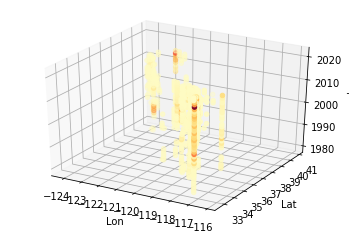

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = ca_3['x']
y = ca_3['y']
z = ca_3['Year']
val = ca_3['Action Obligation ($)']

ax.scatter(x, y, z, c=val, cmap='YlOrRd', marker='o')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_zlabel('T')

plt.show()

**Transform point cloud into simplical complex**

In [24]:
ca_ar = ca_3[['Year', 'x', 'y']].to_numpy()

In [25]:
skeleton = gd.RipsComplex(points = ca_ar, max_edge_length = 0.2)

In [26]:
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 4)

In [27]:
Rips_simplex_tree_sample.dimension()

4

In [28]:
Rips_simplex_tree_sample.num_vertices()

879

In [29]:
Rips_simplex_tree_sample.num_simplices()

2927

In [30]:
rips_generator = Rips_simplex_tree_sample.get_filtration()

In [31]:
%%capture
rips_list = list(rips_generator)
for splx in rips_list[0:-1] :
    print(splx)

In [32]:
BarCodes_Rips = Rips_simplex_tree_sample.persistence()

In [33]:
%%capture
for i in range(20):
    print(BarCodes_Rips[i])

WARNING - 2021-10-16 14:25:46,880 - __init__ - usetex mode requires TeX.


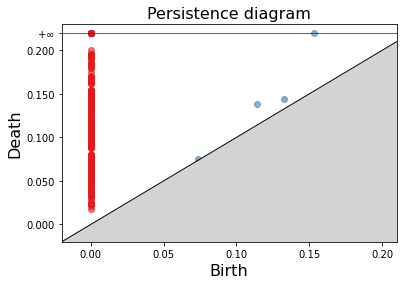

In [34]:
gd.plot_persistence_diagram(BarCodes_Rips)

**Point cloud data with Open3D**

In [35]:
pcd = o3d.geometry.PointCloud()

In [36]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(ca_ar[:,:3])
#pcd.colors = o3d.utility.Vector3dVector(ca_ar[:,3:4]/255)
#pcd.normals = o3d.utility.Vector3dVector(ca_ar[:,6:9])

In [37]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

INFO - 2021-10-16 14:25:52,048 - utils - NumExpr defaulting to 2 threads.


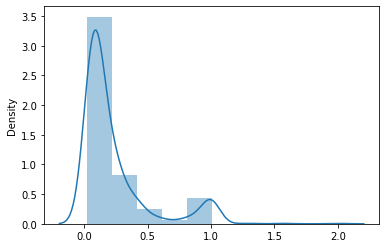

In [38]:
dist = pd.Series(distances)
sns.distplot(dist, bins=10)

In [39]:
#poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(ca_ar, depth=8, width=0, scale=1.1)

**Interactive point clouds with Plotly**

In [40]:
trace1 = go.Scatter3d(
    x = ca_3['x'],
    y = ca_3['y'],
    z = ca_3['Year'],
    mode='markers',
    marker=dict(
        size=4,
        color=ca_3['Action Obligation ($)'],                
        colorscale='spectral',   
        opacity=0.8
        
    )
)

data = [trace1]
layout = go.Layout(
    scene = dict(
                    xaxis = dict(
                        title='lon'),
                    yaxis = dict(
                        title='lat'),
                    zaxis = dict(
                        title='time'),),
    margin=dict(
        r=20, b=10, l=10, t=10
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()
#py.iplot(fig, filename='3d-scatter-colorscale')
#plotly.plot(fig, filename='/content/drive/MyDrive/hub_zone_dod/interactive_plt')


**Moran's I Time Series**

In [41]:
ca_lattice = pd.read_csv(r'/content/drive/MyDrive/Spatiotemp/final project/ca_invest_spacetime.csv')

In [42]:
ca_shp = gpd.read_file(r'/content/drive/MyDrive/hub_zone_dod/ca_geo_invest.shp')

In [43]:
ca_shp_new = ca_shp

In [44]:
ca_shp.head()

,ZIP,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,geometry
0,93311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3769.5,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"MULTIPOLYGON (((-119.09215 35.32176, -119.0921..."
1,91504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233000.0,184000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"POLYGON ((-118.34858 34.20846, -118.34856 34.2..."
2,91789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1951015.43,7919059.97,8078029.02,16144537.45,11936626.59,5592327.27,1168020.91,"POLYGON ((-117.88360 34.01488, -117.88372 34.0..."
3,91702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13772.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,7688549.60,0.00,-100015.61,0.00,"POLYGON ((-117.88099 34.16501, -117.88086 34.1..."
4,91765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3086.16,0.00,0.00,0.00,0.00,0.00,0.00,"POLYGON ((-117.82337 34.01083, -117.82342 34.0..."


In [45]:
#create contiguity and nearest neighbor weights
w_rook = Rook.from_dataframe(ca_shp)
w_queen = Queen.from_dataframe(ca_shp)
w_KNN = KNN.from_dataframe(ca_shp, k=3)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 65 disconnected components.
 There are 40 islands with ids: 1, 5, 9, 11, 12, 17, 18, 21, 25, 28, 31, 35, 36, 38, 47, 60, 61, 63, 73, 75, 76, 82, 83, 94, 95, 99, 103, 106, 109, 113, 114, 115, 116, 127, 140, 141, 142, 164, 169, 173.

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 64 disconnected components.
 There are 39 islands with ids: 1, 5, 9, 11, 12, 17, 18, 21, 25, 28, 31, 35, 36, 38, 47, 60, 61, 63, 73, 75, 76, 82, 83, 94, 95, 99, 103, 106, 109, 113, 114, 115, 116, 127, 140, 141, 142, 164, 173.



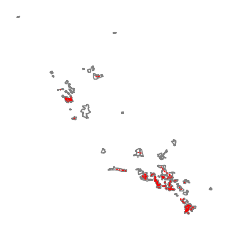

In [46]:
#plot queen lattice to check work
ax = ca_shp.plot(edgecolor='grey', facecolor='w')
ca_shp,ax = w_queen.plot(ca_shp,ax=ax, 
        edge_kws= dict(color='r', linestyle=':', linewidth=1),
        node_kws = dict(marker=''))
ax.set_axis_off()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



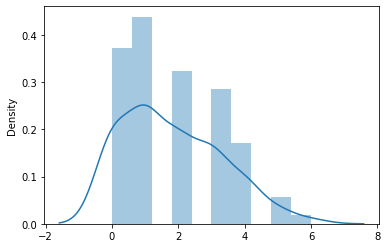

In [47]:
queen_card = pd.Series(w_queen.cardinalities) #create series that describes queen adjacencies
sns.distplot(queen_card, bins=10) #plot histogram

In [48]:
%%capture
list(ca_shp_new)

In [49]:
time_series = ['1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021']

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(time_series):
    # select the axis where the map will go
    for j in range(i):
      ax = axs[j]
    # Plot the map
    ca_shp_new.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()
##SOURCE: https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html

In [52]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [esda.moran.Moran(ca_shp_new[year], w_queen) for year in time_series]
# Structure results as a list of tuples
mi_results = [
    (datum, res.I, res.p_sim) for datum,res in zip(time_series, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Datum', "Moran's I", 'P-value']
).set_index('Datum')
table
##SOURCE: https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html

('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 60, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 63, ' is an island (no neighbors)')
('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('W

,Moran's I,P-value
Datum,,
1980,-0.014466,0.053
1981,-0.014466,0.042
1982,-0.014466,0.069
1983,-0.019641,0.181
1984,-0.016966,0.468
1985,-0.015557,0.375
1986,-0.015639,0.489
1987,-0.013467,0.472
1988,0.005874,0.145


In [75]:
x_label = []
for i in table['Datum']:
  x_label.append(i)

INFO - 2021-10-16 15:00:59,901 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2021-10-16 15:00:59,912 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


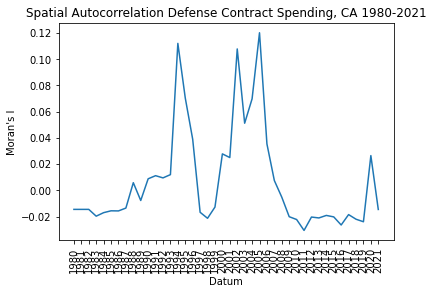

In [79]:
sns.lineplot(x='Datum', y="Moran's I", data=table)
#sns.lineplot(x='Datum', y = "P-value", data= table)
plt.draw()
for label in ax.xaxis.get_ticklabels(x_label)[::]:
    label.set_visible(False)
plt.xticks(rotation = 90)
plt.title('Spatial Autocorrelation Defense Contract Spending, CA 1980-2021')
plt.show()

**Simplicial complex using Keppler Mapper**



In [54]:
list(ca_3)

['Unnamed: 0', 'geometry', 'Year', 'ZIP', 'Action Obligation ($)', 'x', 'y']

In [55]:
feature_names = [c for c in ca_3.columns if c not in ['Unnamed: 0', 'geometry', 'ZIP', 'Action Obligation ($)']]
ca_3['Action Obligation ($)'] = ca_3['Action Obligation ($)'].apply(lambda x: 1 if x > 0 else 0)
X = np.array(ca_3[feature_names])
#X.reshape(1, -1)
y = np.array(ca_3['Action Obligation ($)'])

# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine both lenses to get a 2-D [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      #N_cubes=15,
                      #Perc_overlap=0.7,
                      clusterer=sklearn.cluster.KMeans(n_clusters=3,
                                                       random_state=42))

In [56]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [57]:
color_values = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                 color_values,  
                                                                 color_function_name='Distance to x-min', 
                                                                 colorscale=my_colorscale)

# assign to node['custom_tooltips']  the node label (0 for benign, 1 for malignant)
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

In [58]:
bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [59]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Space-time Topological Network: CA Military Investment',  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor, 
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

In [60]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [61]:
from google.colab import output
output.enable_custom_widget_manager()

In [62]:
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [63]:
investment_dict = {0: 'no', 1: 'yes'}
tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips

new_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y[scomplex['nodes'][node['name']]]
    member_labels = [investment_dict[id] for id in member_label_ids]
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    
    n_members = label_counts.sum()
    if label_type.shape[0] == 1:
        if label_type[0] == 'no':
            new_color.append(0)
        else:
            new_color.append(1)
    else:        
        new_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
       
    for i in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[i]) + ': ' + str(label_counts[i]) # append  how many yes/no
                                                                                 # members exist in each node

fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure                                                                
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels
    
fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function  
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of zip codes with investment"
fwn_graph.show()

In [64]:
HBox([fwn_graph, fw1])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

**Time series cluster analysis, Moran's I**

In [65]:
table.reset_index(inplace=True)

In [66]:
list(table)

['Datum', "Moran's I", 'P-value']